# Mantrap Report

In [3]:
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.ioff()

## Example

In [43]:
from IPython.display import HTML

import mantrap
import torch

from mantrap_evaluation.datasets import scenario_custom_haruki

env, goal, _ = scenario_custom_haruki(env_type=mantrap.environment.PotentialFieldEnvironment)
solver = mantrap.solver.SGradSolver(env=env, goal=goal, t_planning=3, optimize_speed=False)
#ego_trajectory, _ = solver.solve(time_steps=20)

#HTML(solver.visualize_scenes(enforce=True, plot_path_only=True))

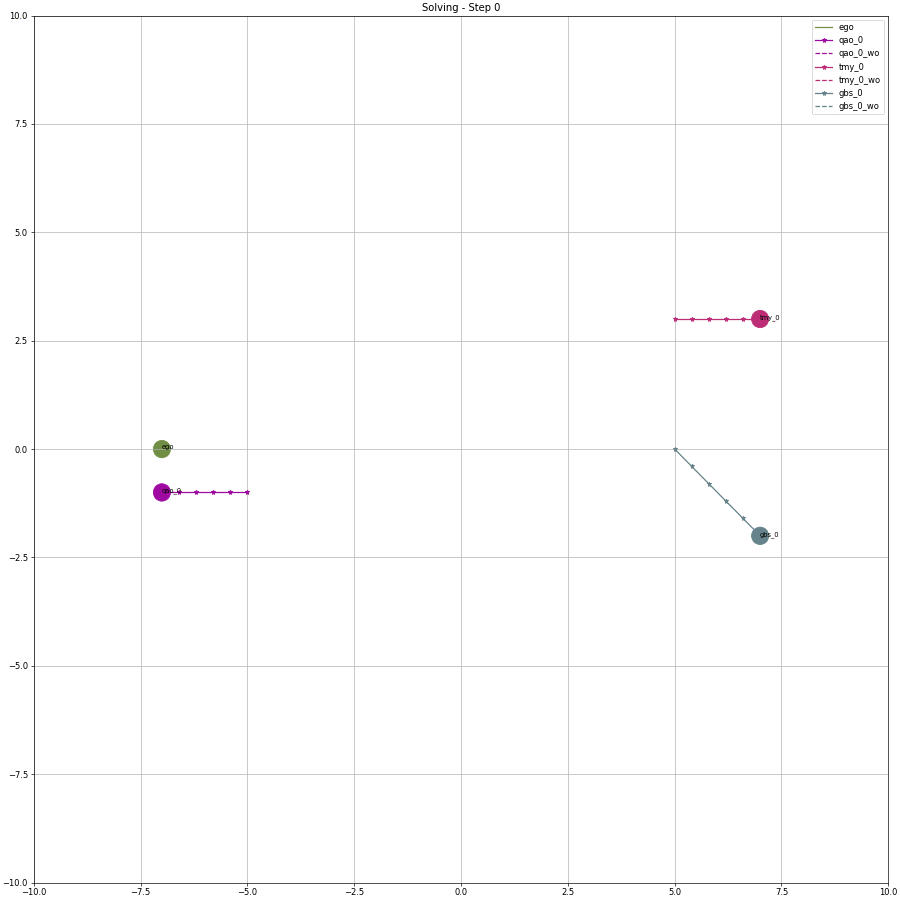

In [56]:
from IPython.display import Image
import mantrap

Image(mantrap.utility.io.build_os_path("outputs/sgrad_t5_haruki.gif"), width=600, height=400)

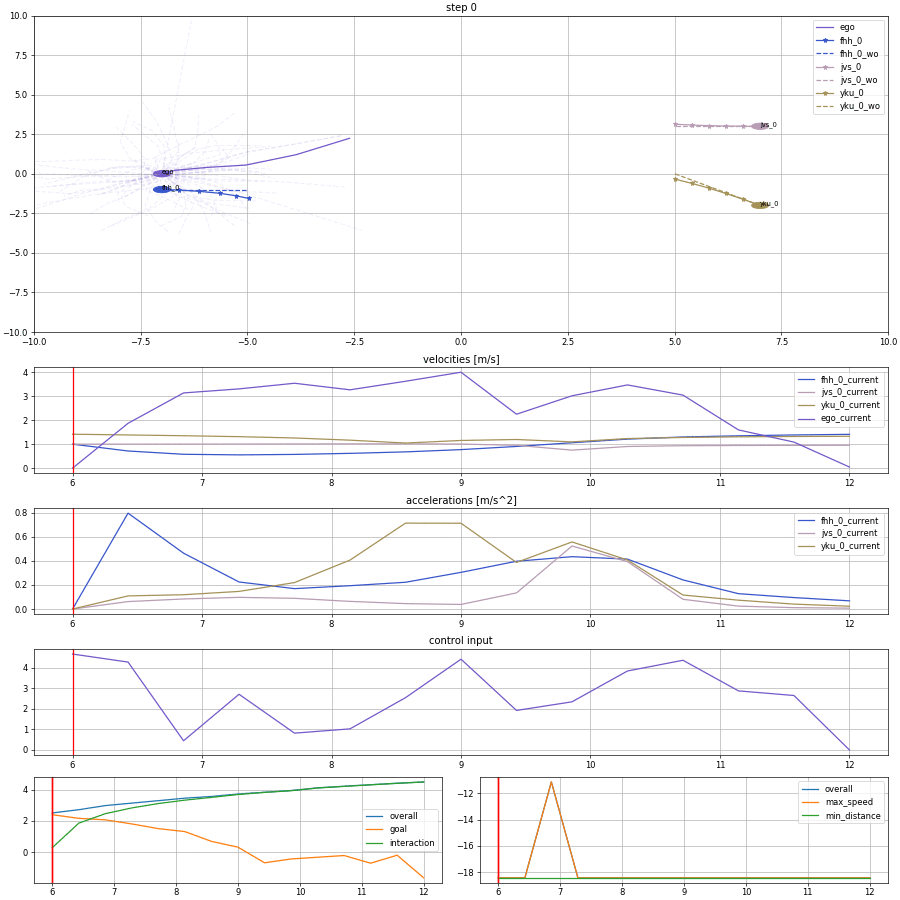

In [55]:
Image(mantrap.utility.io.build_os_path("outputs/mcts_t5_potential_field_haruki_opt.gif"), width=600, height=400)

## Approach

### Optimizatization Formulation

\begin{align}
\min_{x_{ego}} & E [ w_1 J_{int-acc} + w_2 J_{goal} ] \\ 
\text{subject to } & x_{ego}^{k + 1} = f(x_{ego}^k, u_{ego}^k) \\ 
&x_{ego}^0 = x_{init} \\
&|| u_{ego}^k || < \gamma \forall k \in [0, T] \\
&|| x_{ego}^k - x_j^k || > D \forall k \in [0, T],  \forall j \in [0, M]
\end{align}

### Objective Function: Interaction - Acceleration

\begin{align}
J_{interaction-acceleration}(x_{ego}) &= \\
& =\sum_{t = 0}^T \sum_{m = 0}^M || \frac{\delta^2}{\delta t^2} x_m^t - \frac{\delta^2}{\delta t^2} x_{m, wo}^t || \\
& = \frac{1}{dt^2} \sum_{t = 1}^{T - 1} \sum_{m = 0}^M || (x_m^{t - 1} - 2 x_m^t + x_m^{t + 1}) - (x_{m, wo}^{t - 1} - 2 x_{m, wo}^t + x_{m, wo}^{t + 1})) || \\
& = \frac{1}{dt^2} \sum_{t = 1}^{T - 1} \sum_{m = 0}^M || x_m^{t - 1} - 2 x_m^t + x_m^{t + 1}- x_{m, wo}^{t - 1} + 2 x_{m, wo}^t - x_{m, wo}^{t + 1} ||
\end{align}

\begin{align}
\frac{\delta}{\delta x_{ego}^k} J_{interaction-position}(x_{ego}) &= \\ 
& = \frac{\delta}{\delta x_{ego}^k} \sum_{t = 0}^T \sum_{m = 0}^M || x_m^t - x_{m, wo}^t || \\
& = \sum_{t = k}^T  \frac{\delta}{\delta x_{ego}^k} \sum_{m = 0}^M  || x_m^t - x_{m, wo}^t || \\
& = \sum_{t = k}^T  \sum_{m = 0}^M \frac{\delta}{\delta x_{ego}^k} || x_m^t- x_{m, wo}^t || \\
& = \sum_{t = k}^T  \sum_{m = 0}^M \frac{1}{ || x_m^t - x_{m, wo}^t || } \sum_{n=0}^N ([x_m^t]_n- [x_{m, wo}^t]_n) * \frac{\delta}{\delta x_{ego}^k} [x_m^t]_n
\end{align}

### Solver Classes

In [34]:
mantrap.solver.SOLVERS_DICT

{'sgrad': mantrap.solver.sgrad.SGradSolver,
 'ignoring': mantrap.solver.solver_baselines.ignoring.IgnoringSolver,
 'orca': mantrap.solver.solver_baselines.orca.ORCASolver,
 'mcts': mantrap.solver.mc_tree_search.MonteCarloTreeSearch}

### Objectives

In [38]:
mantrap.solver.objectives.OBJECTIVES_DICT

{'control_effort': mantrap.solver.objectives.control_effort.ControlEffortModule,
 'goal': mantrap.solver.objectives.goal.GoalModule,
 'interaction_acc': mantrap.solver.objectives.acc_interact.InteractionAccelerationModule,
 'interaction_pos': mantrap.solver.objectives.pos_interact.InteractionPositionModule}

### Constraints

In [39]:
mantrap.solver.constraints.CONSTRAINTS_DICT

{'control_limits': mantrap.solver.constraints.control_limits.ControlLimitModule,
 'min_distance': mantrap.solver.constraints.min_distance.MinDistanceModule,
 'norm_distance': mantrap.solver.constraints.norm_distance.NormDistanceModule}

### Environment Classes

In [36]:
mantrap.environment.ENVIRONMENTS_DICT

{'social_forces': mantrap.environment.social_forces.SocialForcesEnvironment,
 'trajectron': mantrap.environment.trajectron.Trajectron,
 'kalman': mantrap.environment.simplified.kalman.KalmanEnvironment,
 'orca': mantrap.environment.simplified.orca.ORCAEnvironment,
 'potential_field': mantrap.environment.simplified.potential_field.PotentialFieldEnvironment}

### Initial Condition
For initialization only hard objectives (goal) are used, while the environment of the robot is ignored. Therefore, three initial paths are created going from the current to the goal state straight, and in an up- or down-curved shape, using B-spline interpolation. To track this path (and create feasible initial values for the robot's controls) a MPC implementation as well as a so called "look-ahead P-Controller" were tested, due to a better runtime vs tracking error trade-off the P-controller appraoch is being used for mantrap. 

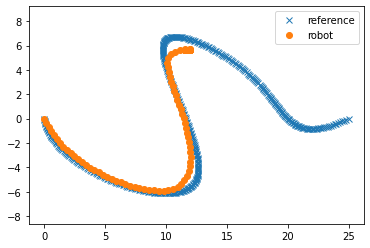

In [26]:
import mantrap
import torch

ax = [0.0, 2.0, 12.5, 10.0, 17.5, 20.0, 25.0]
ay = [0.0, -3.0, -5.0, 6.5, 3.0, 0.0, 0.0]
goal = [ax[-1], ay[-1]]
control_points = torch.stack((torch.tensor(ax), torch.tensor(ay)), dim=1)
cxy_spline = mantrap.utility.maths.spline_interpolation(control_points, num_samples=400)

agent = mantrap.agents.IntegratorDTAgent(position=cxy_spline[0, :], velocity=torch.ones(2) * 1.0, is_robot=True)
controls = mantrap.controller.p_ahead_controller(agent, 
                                                 path=cxy_spline, 
                                                 max_sim_time=100.0, 
                                                 dtc=0.4, 
                                                 speed_reference = 1.0)

cxy_spline_np = cxy_spline.detach().numpy()
trajectory_np = agent.unroll_trajectory(controls, dt=0.4).detach().numpy()

plt.plot(cxy_spline_np[:, 0], cxy_spline_np[:, 1], 'x', label="reference")
plt.plot(trajectory_np[:, 0], trajectory_np[:, 1], 'o', label="robot")
plt.axis("equal")
plt.legend()
plt.show()

### Agent Filtering 
In order to reduce runtime several "agent filtering" algorithms have been tested. These algorithms basically reduce the number of agents that have to be taken into account during trajectory optimization based on (simple) heuristics or (forward) reachability applied on the states the agents are currently in. Forward reachability: 

In [27]:
import torch
import mantrap

agent = mantrap.agents.DoubleIntegratorDTAgent(position=torch.zeros(2), velocity=torch.tensor([2, 3]))
boundary_double = agent.reachability_boundary(time_steps=5, dt=1.0)
agent = mantrap.agents.IntegratorDTAgent(position=torch.zeros(2), velocity=torch.tensor([2, 3]))
boundary_single = agent.reachability_boundary(time_steps=5, dt=1.0)

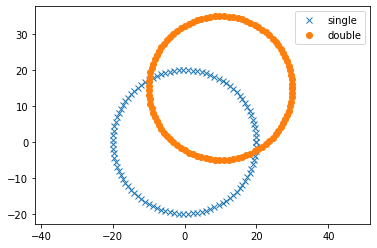

In [28]:
boundary_double_samples = boundary_double.samples().detach().numpy()
boundary_single_samples = boundary_single.samples().detach().numpy()

plt.plot(boundary_single_samples[:, 0], boundary_single_samples[:, 1], 'x', label="single")
plt.plot(boundary_double_samples[:, 0], boundary_double_samples[:, 1], 'o', label="double")
plt.axis('equal')
plt.legend()
plt.show()

In [32]:
mantrap.solver.filter.FILTER_DICT

{'euclidean': mantrap.solver.filter.euclidean.EuclideanModule,
 'no_filter': mantrap.solver.filter.nofilter.NoFilterModule,
 'reachability': mantrap.solver.filter.reachability.ReachabilityModule}

## Documentation

In [16]:
from IPython.display import IFrame

url = "https://simon-schaefer.github.io/mantrap/"
IFrame(url, width=800, height=400)

## Evaluation

In [18]:
import mantrap
import pandas as pd

results_df = pd.read_csv(mantrap.utility.io.build_os_path("outputs/evaluation_ignoring.csv"))
results_df

,Unnamed: 0,solver,scenario,env_type,ego_type,filter,t_planning,eval_env,dt,multiprocessing,ado_effort,directness,ego_effort,minimal_distance,runtime
0,0,ignoring,custom_haruki,social_forces,single_int,euclidean,1,NaN,0.4,True,0.062,1.0,0.503,0.991,0.120
1,1,ignoring,custom_haruki,social_forces,single_int,euclidean,1,NaN,0.4,False,0.062,1.0,0.503,0.991,0.024
2,2,ignoring,custom_haruki,social_forces,single_int,euclidean,3,NaN,0.4,True,0.063,1.0,0.500,0.990,0.121
3,3,ignoring,custom_haruki,social_forces,single_int,euclidean,3,NaN,0.4,False,0.062,1.0,0.500,0.990,0.021
4,4,ignoring,custom_haruki,social_forces,single_int,euclidean,5,NaN,0.4,True,0.059,1.0,0.500,0.990,0.120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517,517,ignoring,eth,potential_field,double_int,reachability,1,NaN,0.4,False,1.160,0.0,0.000,3.671,0.083
518,518,ignoring,eth,potential_field,double_int,reachability,3,NaN,0.4,True,1.079,0.0,1.000,3.671,0.023
519,519,ignoring,eth,potential_field,double_int,reachability,3,NaN,0.4,False,0.837,0.0,1.000,3.671,0.002
520,520,ignoring,eth,potential_field,double_int,reachability,5,NaN,0.4,True,1.047,0.0,1.000,3.671,0.023


In [19]:
import seaborn as sns

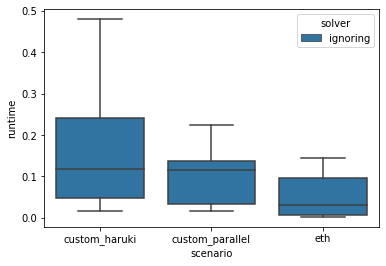

In [20]:
sns.boxplot(x="scenario", y="runtime", hue="solver", data=results_df)
plt.show()

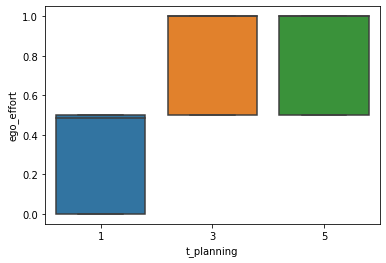

In [21]:
sns.boxplot(x="t_planning", y="ego_effort", data=results_df)
plt.show()

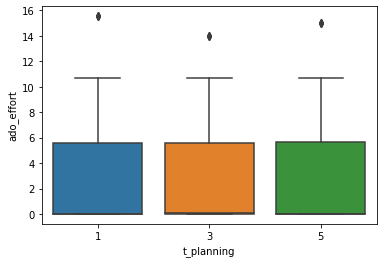

In [22]:
sns.boxplot(x="t_planning", y="ado_effort", data=results_df)
plt.show()